## GNR 650: Advanced topics in deep learning for image analysis
### **Assignment 1:** ResNet-18 on CIFAR10 with few training samples per class
> **TASK:** The task is to take the structure of ResNet-18 model, and train it from scratch on CIFAR10 data, but take very few samples per class. After training, check the test performance. Check the magnitudes of the weights, visualize the kernels at different layers.
### Collaborators: 
[![Munish](https://img.shields.io/badge/22M2153-Munish_Monga-blue)](https://github.com/munish30monga)
[![Aniket](https://img.shields.io/badge/22M2162-Aniket_Thomas-darkgreen)](https://github.com/AniTho)
### Table of Contents:
1. [Introduction](#introduction)
2. [Imporing Libraries](#imporing-libraries)
3. [Hyperparameters](#hyperparameters)
4. [Preprocessing & Data Augmentation](#preprocessing-&-data-augmentation)
5. [Visualizing CIFAR 10 Dataset](#visualizing-cifar-10-dataset)
6. [Preparing Datasets: Subset & Full](#preparing-datasets:-subset-&-full)
7. [Preparing CIFAR 10 Dataloader](#preparing-cifar-10-dataloader)
8. [Training Function](#training-function)
9. [Training ResNet-18 on CIFAR10 Subset Dataset (100 training samples per class)](#training-resnet-18-on-cifar10-subset-dataset-100-training-samples-per-class)
10. [Training Regularized ResNet-18 on CIFAR10 Subset Dataset (100 training samples per class)](#training-regularized-resnet-18-on-cifar10-subset-dataset-100-training-samples-per-class)
11. [Training ResNet-18 on CIFAR10 Full Dataset](#training-resnet-18-on-cifar10-full-dataset)
12. [Training Regularized ResNet-18 on CIFAR10 Full Dataset](#training-regularized-resnet-18-on-cifar10-full-dataset)
13. [Comparing Training Set Performance](#comparing-training-set-performance)
14. [Comparing Test Set Performance](#comparing-test-set-performance)
15. [Plotting Train & Test Accuracy for Non-Regularized Models](#plotting-train-&-test-accuracy-for-non-regularized-models)
16. [Plotting Train & Test Accuracy for Regularized Models](#plotting-train-&-test-accuracy-for-regularized-models)
17. [Observations: Training and Test Set Performance](#observations:-training-and-test-set-performance)
18. [Saving Best Models](#saving-best-models)
19. [Comparing Weight Distributions of Non-Regularized Models](#comparing-weight-distributions-of-non-regularized-models)
20. [Comparing Weight Distributions of Regularized Models](#comparing-weight-distributions-of-regularized-models)
21. [Observations: Weight Distributions](#observations:-weight-distributions)
22. [Visualizing Kernels of Non-Regularized Models](#visualizing-kernels-of-non-regularized-models)
23. [Visualizing Kernels of Regularized Models](#visualizing-kernels-of-regularized-models)
24. [Observations: Visualizing Kernels](#observations:-visualizing-kernels)
25. [Conclusion](#conclusion)


### Introduction

We analyze the performance and characteristics of the `ResNet-18` model on the `CIFAR10` dataset under two different settings:

1. **Subset Dataset**: Training the model with only 100 samples per class.
2. **Full Dataset**: Training the model on the entire CIFAR10 dataset. (i.e. 5000 samples per class)

For each scenario, we evaluate and make comparisons for two versions of models: **Regularized** and **Non-Regularized** in order to study the effects of limited data on overfitting.


### Imporing Libraries

In [1]:
import torch
from torchvision import models
from torchvision import datasets
from torchvision import transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

### Hyperparameters <a class="anchor" id="#hyperparameters"></a>

In [2]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
inv_mean = -mean
inv_std = 1/std
max_n = 100
batch_size = 32
learning_rate = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 40
seed = 42                   # random seed
print_summary = False

### Preprocessing & Data Augmentation

In [3]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean = mean, 
                                                            std = std)])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean = mean, 
                                                            std = std)])

# For the purposes of visualizing images
inv_transforms = transforms.Compose([transforms.Normalize(mean = (0., 0., 0.),
                                                          std = inv_std),
                                     transforms.Normalize(mean = inv_mean,
                                                          std = (1., 1., 1,))])

cifar10 = datasets.CIFAR10(root = './data/', train=True, transform=train_transforms, download=True)
cifar10_test = datasets.CIFAR10(root='./data/', train=False, transform=test_transforms, download=True)
cifar10_classes = cifar10.classes
images, labels = cifar10.data, np.array(cifar10.targets)
test_images, test_labels = cifar10_test.data, np.array(cifar10_test.targets)

Files already downloaded and verified
Files already downloaded and verified


### Visualizing CIFAR 10 Dataset

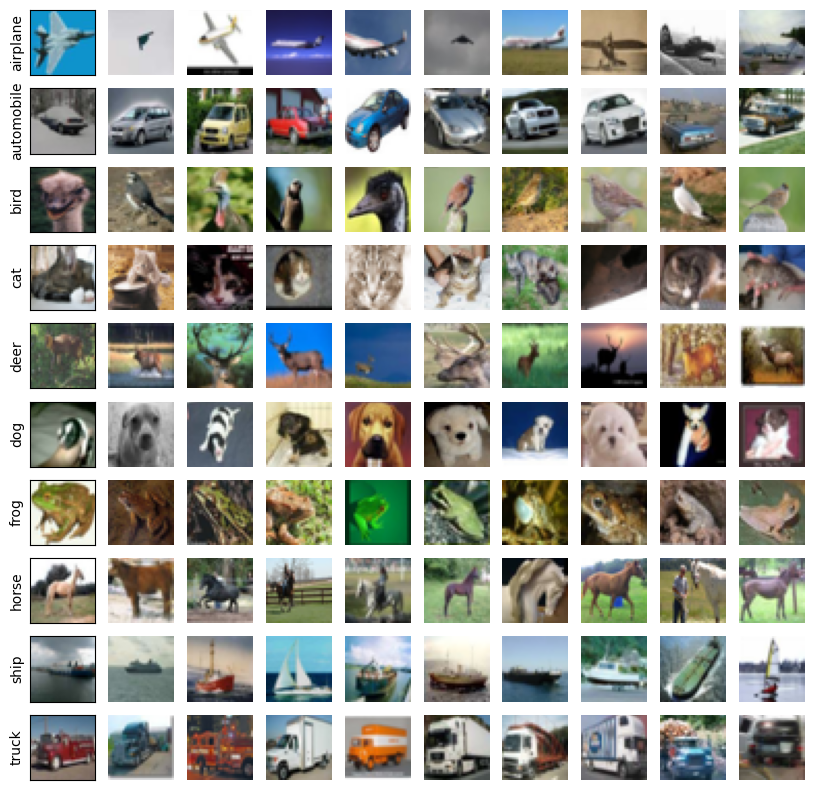

In [4]:
num_per_class = 10
fig, axes = plt.subplots(nrows=num_per_class, ncols=len(cifar10_classes), figsize = (10,10))
for idx, cls_name in enumerate(cifar10_classes):
    lbl_idxs = np.where(labels == idx)[0]
    for row in range(num_per_class):
        disp_idx = random.choice(lbl_idxs)
        img = images[disp_idx]
        axes[idx][row].imshow(img)
        if row == 0:
            axes[idx][row].set_ylabel(cls_name)
            axes[idx][row].set_xticks([])
            axes[idx][row].set_yticks([])
            continue
        axes[idx][row].axis('off')

### Preparing Datasets: Subset & Full

In [5]:
np.random.seed(seed)
data_idxs_subset = []                           # 100 training images per class
data_idxs_full = []                             # 5000 training images per class
for idx, _ in enumerate(cifar10_classes):   
    lbl_idxs = np.where(labels == idx)[0]
    idxs_subset = np.random.choice(lbl_idxs, max_n, replace=False)
    data_idxs_subset.extend(idxs_subset)
    data_idxs_full.extend(lbl_idxs)
print("Size of subset dataset: ", len(data_idxs_subset))        # 100 x 10 = 1000
print("Size of full dataset: ", len(data_idxs_full))            # 5000 x 10 = 50000

Size of subset dataset:  1000
Size of full dataset:  50000


### Preparing CIFAR 10 Dataloader

In [6]:
class Cifar10(Dataset):
    def __init__(self, images, labels, idxs, transform = None):
        self.images = images[idxs]
        self.labels = labels[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        lbl = self.labels[idx]
        if self.transform:
            if not isinstance(img, torch.Tensor):
                img = Image.fromarray(img)
                img = self.transform(img)
        return img, lbl
    
# Create two datasets, one for subset and one for full
train_dataset_subset = Cifar10(images, labels, data_idxs_subset, train_transforms)
train_dataset_full = Cifar10(images, labels, data_idxs_full, train_transforms)
test_dataset = Cifar10(test_images, test_labels, list(range(len(test_images))), test_transforms)
 
# Create DataLoaders
trainloader_subset = DataLoader(train_dataset_subset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
trainloader_full = DataLoader(train_dataset_full, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

### Training Function

In [7]:
def train_model(trainloader, testloader, model_name, print_summary, regularize = False):
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, len(cifar10_classes))
    model = model.to(device)
    if print_summary:
        summary(model=model, input_size=(3,32,32))
    criterion = nn.CrossEntropyLoss()
    if regularize:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.03)
    else:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    accuracy = []
    test_accuracy = []
    best_test_accuracy = 0.0
    best_train_accuracy = 0.0

    # Save Names
    best_model = f'best_model_{model_name}'
    final_model = f'{model_name}'
    if regularize:
        best_model+='_regularize'
        final_model+='_regularize'

    print(f"Training {model_name}")
    for epoch in range(1, epochs+1):
        pbar = tqdm(trainloader, total=len(trainloader), leave=False)
        epoch_loss = 0.0
        model.train()
        for imgs, lbls in pbar:
            imgs, lbls = imgs.to(device), lbls.to(device)
            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, lbls)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            pbar.set_postfix(train_loss=loss.item())

        epoch_loss = epoch_loss / len(trainloader)
        model.eval()
        no_of_correct, total = 0, 0
        with torch.no_grad():
            for imgs, lbls in trainloader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                out = model(imgs)
                _, preds = out.max(-1)
                no_of_correct += (preds == lbls).cpu().numpy().sum()
                total += len(lbls)

        epoch_accuracy = no_of_correct / total
        losses.append(epoch_loss)
        accuracy.append(epoch_accuracy)


        no_of_correct, total = 0, 0
        with torch.no_grad():
            for imgs, lbls in testloader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                out = model(imgs)
                _, preds = out.max(-1)
                no_of_correct += (preds == lbls).cpu().numpy().sum()
                total += len(lbls)

        test_epoch_accuracy = no_of_correct / total
        test_accuracy.append(test_epoch_accuracy)
        if best_test_accuracy < test_epoch_accuracy:
            best_test_accuracy = test_epoch_accuracy
            torch.save(model.state_dict(), f'./model_weights/{best_model}.pt')
        if best_train_accuracy < epoch_accuracy:
            best_train_accuracy = epoch_accuracy
            torch.save(model.state_dict(), f'./model_weights/{final_model}.pt')

        print(f"{'*'*10} EPOCH {epoch:2}/{epochs} {'*'*10}")
        print(f'''{"#"*33}
Train Loss: {epoch_loss:5.3f}, Train Accuracy: {epoch_accuracy*100:5.2f}
{"#"*33}''')
    model.load_state_dict(torch.load(f'./model_weights/{final_model}.pt'))
    return model,losses,accuracy,test_accuracy

### Training ResNet-18 on CIFAR10 Subset Dataset (100 training samples per class)

In [ ]:
resnet18_subset, losses_subset, \
accuracy_subset, test_accuracy_subset = train_model(trainloader_subset, testloader,
                                                    "ResNet18_Subset", 
                                                    print_summary=print_summary,
                                                    regularize=False)

### Training Regularized ResNet-18 on CIFAR10 Subset Dataset (100 training samples per class)

In [ ]:
resnet18_subset_reg, losses_subset_reg, \
accuracy_subset_reg, test_accuracy_subset_reg = train_model(trainloader_subset, 
                                                    testloader,
                                                    "ResNet18_Subset", 
                                                    print_summary=print_summary,
                                                    regularize=True)

### Training ResNet-18 on CIFAR10 Full Dataset

In [ ]:
resnet18_full, losses_full, \
accuracy_full, test_accuracy_full = train_model(trainloader_full, testloader,
                                                "ResNet18_Full", 
                                                print_summary=print_summary, 
                                                regularize=False)

### Training Regularized ResNet-18 on CIFAR10 Full Dataset

In [ ]:
resnet18_full_reg, losses_full_reg, \
accuracy_full_reg, test_accuracy_full_reg = train_model(trainloader_full, 
                                                testloader,
                                                "ResNet18_Full", 
                                                print_summary=print_summary, 
                                                regularize=True)

### Comparing Training Set Performance

In [12]:
training_accuracy_subset = accuracy_subset[-1]
training_accuracy_full = accuracy_full[-1]
training_accuracy_subset_reg = accuracy_subset_reg[-1]
training_accuracy_full_reg = accuracy_full_reg[-1]
print(f"Training Accuracy of ResNet18 on subset CIFAR10 Dataset (Non Regularized):\
 {training_accuracy_subset * 100:.2f}%")
print(f"Training Accuracy of ResNet18 on full CIFAR10 Dataset (Non Regularized):\
 {training_accuracy_full * 100:.2f}%")
print(f"Training Accuracy of ResNet18 on subset CIFAR10 Dataset (Regularized):\
 {training_accuracy_subset_reg * 100:.2f}%")
print(f"Training Accuracy of ResNet18 on full CIFAR10 Dataset (Regularized):\
 {training_accuracy_full_reg * 100:.2f}%")

Training Accuracy of ResNet18 on subset CIFAR10 Dataset (Non Regularized): 98.10%
Training Accuracy of ResNet18 on full CIFAR10 Dataset (Non Regularized): 99.43%
Training Accuracy of ResNet18 on subset CIFAR10 Dataset (Regularized): 83.00%
Training Accuracy of ResNet18 on full CIFAR10 Dataset (Regularized): 63.64%


### Comparing Test Set Performance

In [13]:
testing_accuracy_subset = test_accuracy_subset[-1]
testing_accuracy_full = test_accuracy_full[-1]
testing_accuracy_subset_reg = test_accuracy_subset_reg[-1]
testing_accuracy_full_reg = test_accuracy_full_reg[-1]
print(f"Testing Accuracy of ResNet18 on subset CIFAR10 Dataset (Non Regularized):\
 {testing_accuracy_subset * 100:.2f}%")
print(f"Testing Accuracy of ResNet18 on full CIFAR10 Dataset (Non Regularized):\
 {testing_accuracy_full * 100:.2f}%")
print(f"Testing Accuracy of ResNet18 on subset CIFAR10 Dataset (Regularized):\
 {testing_accuracy_subset_reg * 100:.2f}%")
print(f"Testing Accuracy of ResNet18 on full CIFAR10 Dataset (Regularized):\
 {testing_accuracy_full_reg * 100:.2f}%")

Testing Accuracy of ResNet18 on subset CIFAR10 Dataset (Non Regularized): 38.36%
Testing Accuracy of ResNet18 on full CIFAR10 Dataset (Non Regularized): 77.65%
Testing Accuracy of ResNet18 on subset CIFAR10 Dataset (Regularized): 34.20%
Testing Accuracy of ResNet18 on full CIFAR10 Dataset (Regularized): 61.27%


### Plotting Train & Test Accuracy for Non-Regularized Models

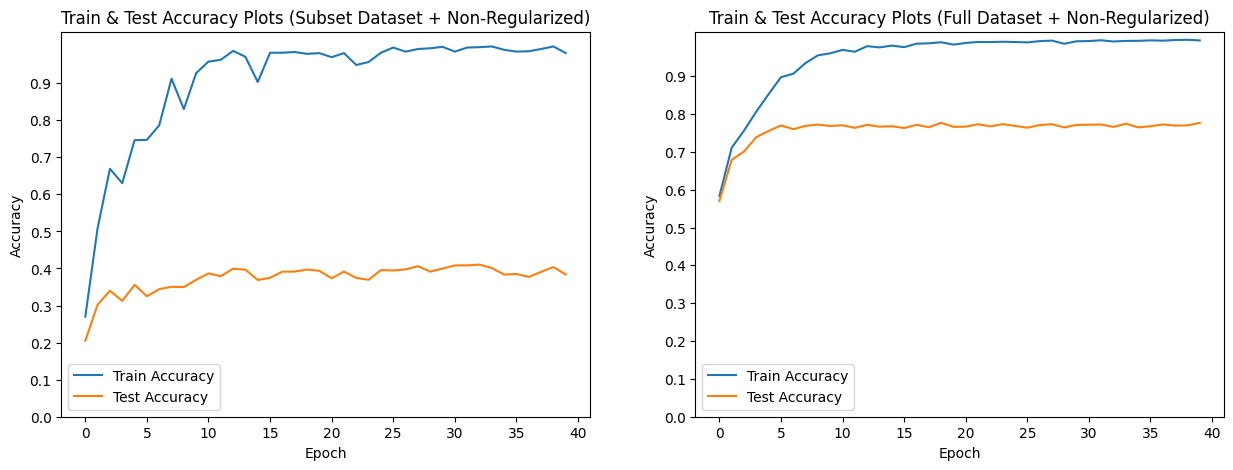

In [14]:
# Plotting accuracy for train and test set
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(accuracy_subset, label="Train Accuracy")
axes[0].plot(test_accuracy_subset, label="Test Accuracy")
axes[0].set_title('Train & Test Accuracy Plots (Subset Dataset + Non-Regularized)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_yticks(np.arange(0.0, 1.0, 0.1))
axes[0].legend()

axes[1].plot(accuracy_full, label="Train Accuracy")
axes[1].plot(test_accuracy_full, label="Test Accuracy")
axes[1].set_title('Train & Test Accuracy Plots (Full Dataset + Non-Regularized)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_yticks(np.arange(0.0, 1.0, 0.1))

plt.show()

### Plotting Train & Test Accuracy for Regularized Models

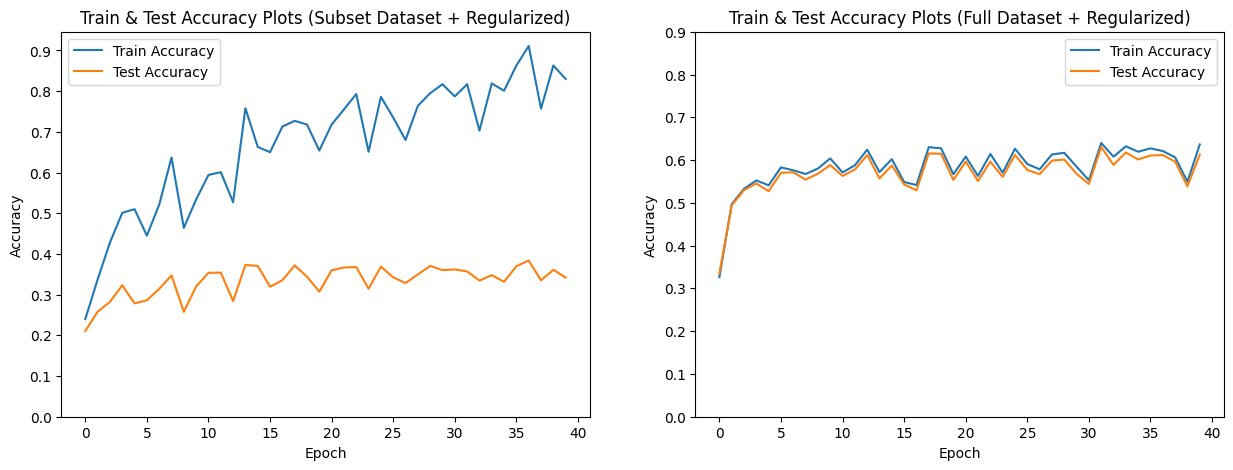

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(accuracy_subset_reg, label="Train Accuracy")
axes[0].plot(test_accuracy_subset_reg, label="Test Accuracy")
axes[0].set_title('Train & Test Accuracy Plots (Subset Dataset + Regularized)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_yticks(np.arange(0.0, 1.0, 0.1))
axes[0].legend()

axes[1].plot(accuracy_full_reg, label="Train Accuracy")
axes[1].plot(test_accuracy_full_reg, label="Test Accuracy")
axes[1].set_title('Train & Test Accuracy Plots (Full Dataset + Regularized)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_yticks(np.arange(0.0, 1.0, 0.1))
axes[1].legend()

plt.show()

### Observations: Training and Test Set Performance
On various runs of the four models, we found the following results (approximated across runs):

| Non-Regularised Models on: | Subset Dataset | Full Dataset |      | Regularised Models on:     | Subset Dataset | Full Dataset | 
|----------------------------|----------------|--------------|------|----------------------------|----------------|--------------|          
| Training Accuracy          | ~100%          | ~100%        |      | Training Accuracy          | ~50%           | ~50%         |
| Test Accuracy              | ~40%           | ~80%         |      | Test Accuracy              | ~30%           | ~50%         |  


**Observations:**
- **Subset Dataset (Non-Regularized Models)**: The models overfits given the limited amount of data, leading to higher training accuracy but potentially lower test accuracy.
- **Full Dataset (Non-Regularized Models)**: With more data, the model is less likely to overfit, resulting in potentially better generalization to the test set. The modesl still overfits but to a lesser extent.
- **Subset Dataset (Regularized Models)**: Regularization techniques might help in preventing overfitting, even with limited data.
- **Full Dataset (Regularized Models)**: Combining regularization with a larger dataset yield the best performance, as the model benefits from both more data and constraints that prevent overfitting.

### Saving Best Models

In [16]:
def build_model(weights_path = './model_weights/best_model.pt'):
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, len(cifar10_classes))
    model = model.to(device)
    model.load_state_dict(torch.load(weights_path))
    return model

### Comparing Weight Distributions of Non-Regularized Models

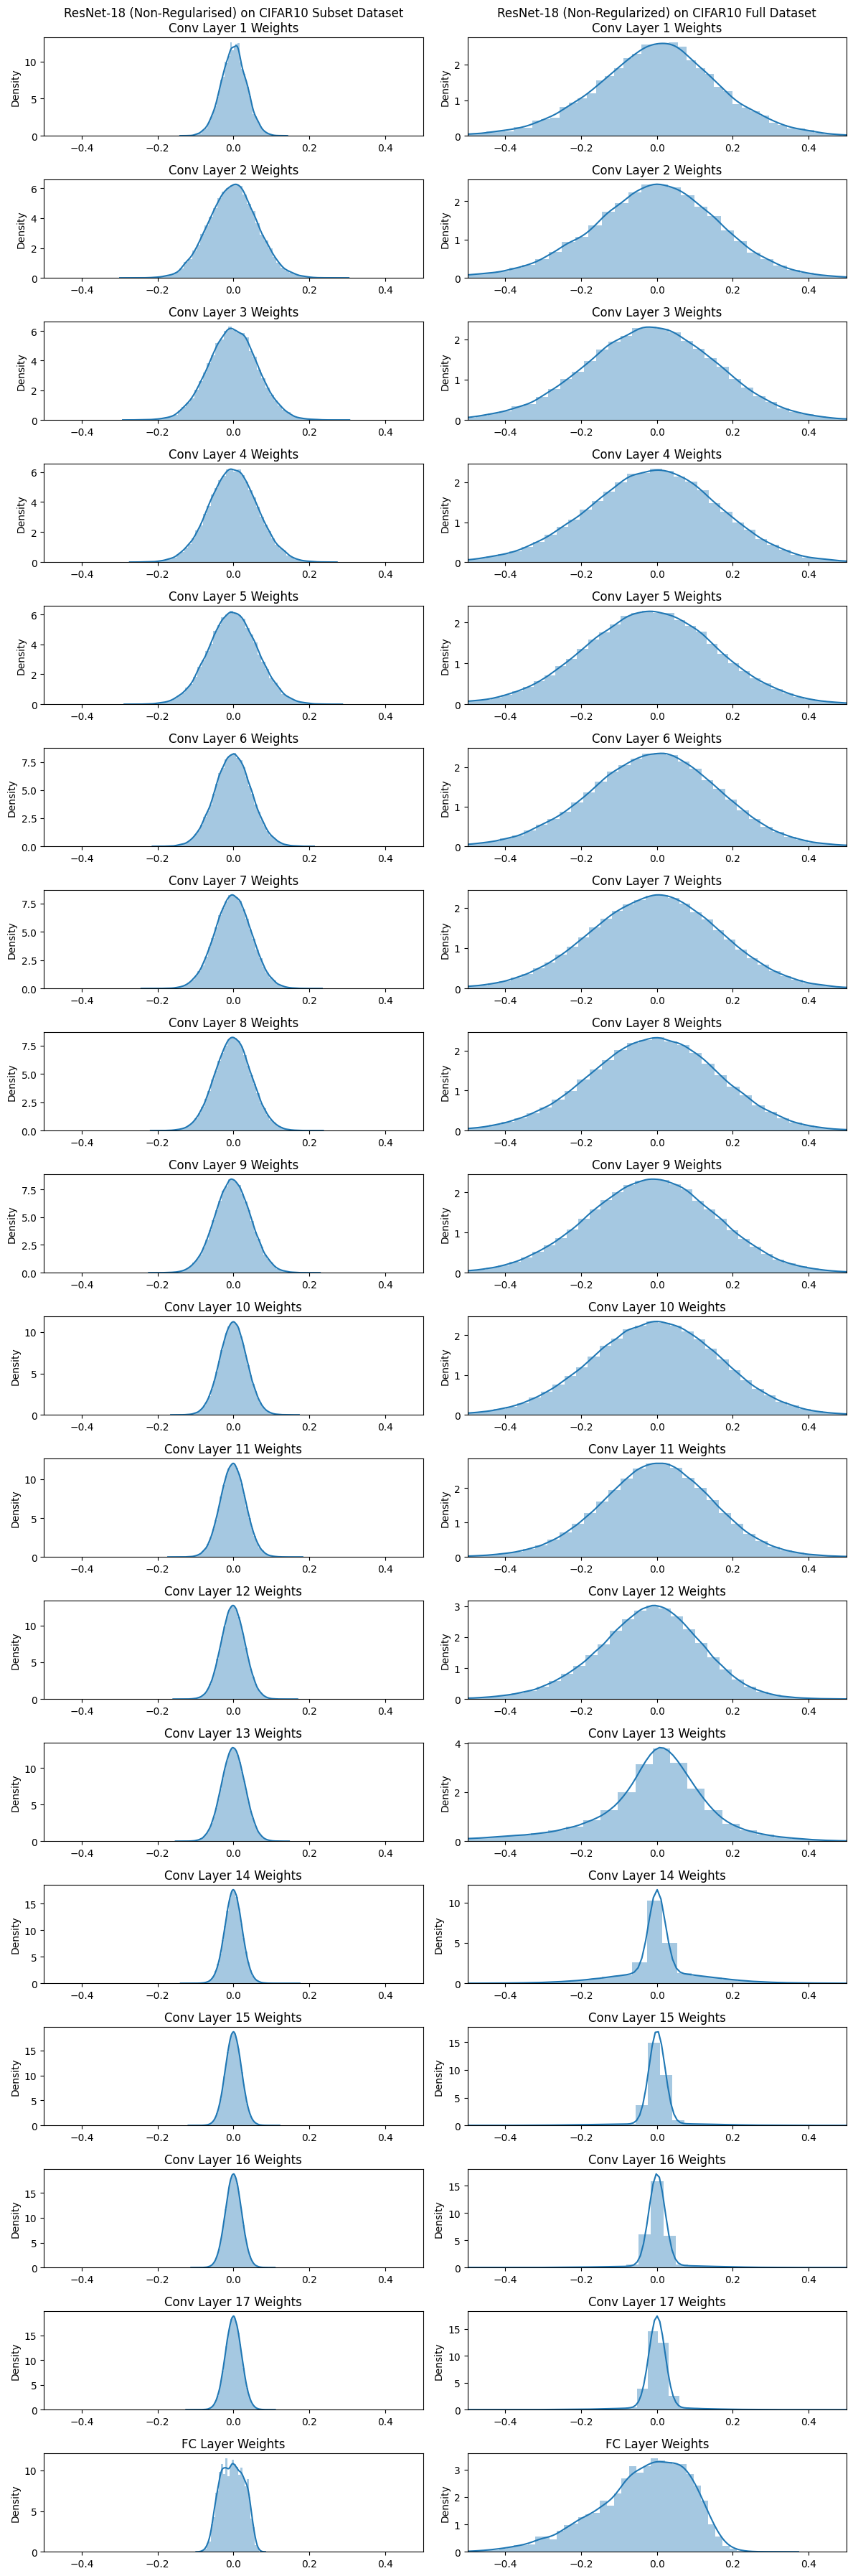

In [17]:
subset_best_non_regularized = build_model('./model_weights/best_model_ResNet18_Subset.pt')
Full_best_non_regularized = build_model('./model_weights/best_model_ResNet18_Full.pt')
models_list = [subset_best_non_regularized, Full_best_non_regularized]
model_names = ["ResNet-18 (Non-Regularised) on CIFAR10 Subset Dataset", \
               "ResNet-18 (Non-Regularized) on CIFAR10 Full Dataset"]

fig, axes = plt.subplots(nrows=18, ncols=2, figsize=(12, 36))
conv_layer = 1
subset_norms = {}
full_norms = {}

for layer_index in range(18):
    for model_index, model in enumerate(models_list):
        current_layer = None
        layer_count = 0
        for layer in model.named_modules():
            if layer[0].find('conv') != -1:
                if layer_count == layer_index:
                    current_layer = layer
                    break
                layer_count += 1
            elif layer[0].find('fc') != -1 and layer_index == 17:  
                current_layer = layer
                break
        
        if current_layer:
            layer_weights = current_layer[1].weight.cpu().detach().clone().numpy().reshape(-1, 1)
            if current_layer[0].find('conv') != -1:
                title = f"Conv Layer {conv_layer} Weights"
                if model_index == 1:
                    conv_layer += 1
            else:
                title = f"FC Layer Weights"
            
            if model_index == 0:
                subset_norms[title] = np.linalg.norm(layer_weights)
            if model_index == 1:
                full_norms[title] = np.linalg.norm(layer_weights)

            if layer_index == 0:
                title = f"{model_names[model_index]}\n{title}"
            sns.distplot(x=layer_weights, ax=axes[layer_index, model_index]).set(title=title)
            axes[layer_index, model_index].set_xlim(-0.5, 0.5)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'ResNet-18 (Non-Regularized) on CIFAR10 Full Dataset')

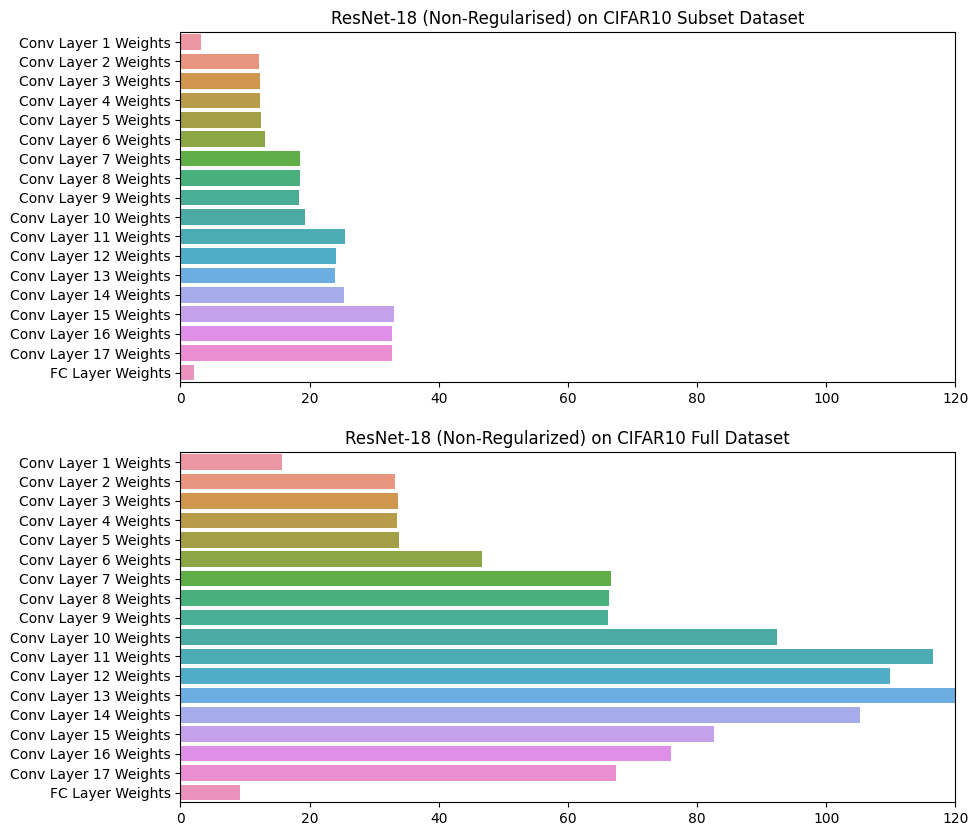

In [18]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (10,10))
layer, norms = zip(*subset_norms.items())
sns.barplot(y = np.array(layer), x = np.array(norms), ax = axes[0])
axes[0].set_xlim(0,120)
axes[0].set_title(model_names[0])
layer, norms = zip(*full_norms.items())
sns.barplot(y = np.array(layer), x = np.array(norms), ax = axes[1])
axes[1].set_xlim(0,120)
axes[1].set_title(model_names[1])

### Comparing Weight Distributions of Regularized Models

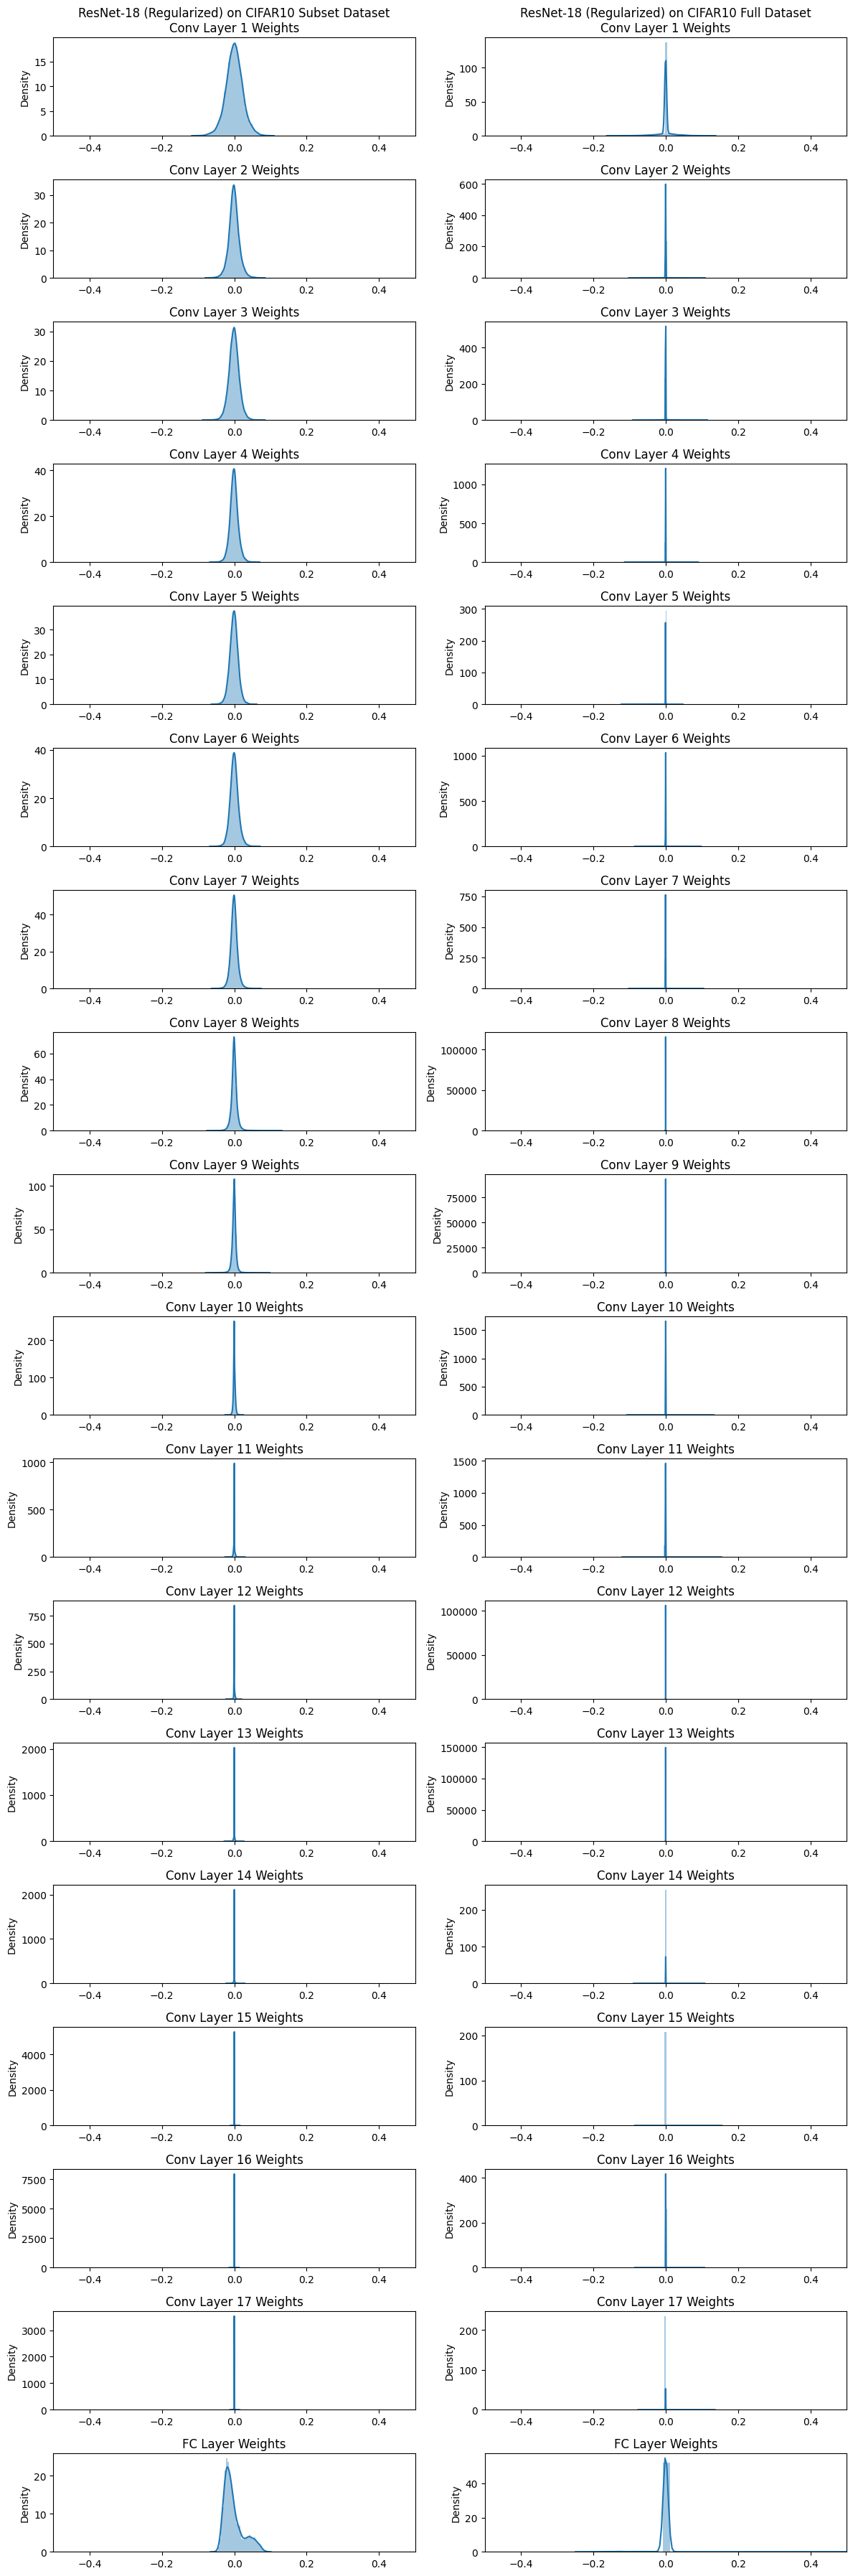

In [19]:
Full_best_regularized = build_model('./model_weights/best_model_ResNet18_Full_regularize.pt')
subset_best_regularized = build_model('./model_weights/best_model_ResNet18_Subset_regularize.pt')
models_list = [subset_best_regularized, Full_best_regularized]
model_names = ["ResNet-18 (Regularized) on CIFAR10 Subset Dataset", \
               "ResNet-18 (Regularized) on CIFAR10 Full Dataset"]

fig, axes = plt.subplots(nrows=18, ncols=2, figsize=(12, 36))
conv_layer = 1
subset_norms ={}
full_norms = {}
for layer_index in range(18):
    for model_index, model in enumerate(models_list):
        current_layer = None
        layer_count = 0
        for layer in model.named_modules():
            if layer[0].find('conv') != -1:
                if layer_count == layer_index:
                    current_layer = layer
                    break
                layer_count += 1
            elif layer[0].find('fc') != -1 and layer_index == 17:  
                current_layer = layer
                break
        
        if current_layer:
            layer_weights = current_layer[1].weight.cpu().detach().clone().numpy().reshape(-1, 1)
            if current_layer[0].find('conv') != -1:
                title = f"Conv Layer {conv_layer} Weights"
                if model_index == 1:
                    conv_layer += 1
            else:
                title = f"FC Layer Weights"

            if model_index == 0:
                subset_norms[title] = np.linalg.norm(layer_weights)
            if model_index == 1:
                full_norms[title] = np.linalg.norm(layer_weights)
                
            if layer_index == 0:
                title = f"{model_names[model_index]}\n{title}"
            sns.distplot(x=layer_weights, ax=axes[layer_index, model_index]).set(title=title)
            axes[layer_index, model_index].set_xlim(-0.5, 0.5)

plt.tight_layout()
plt.show()

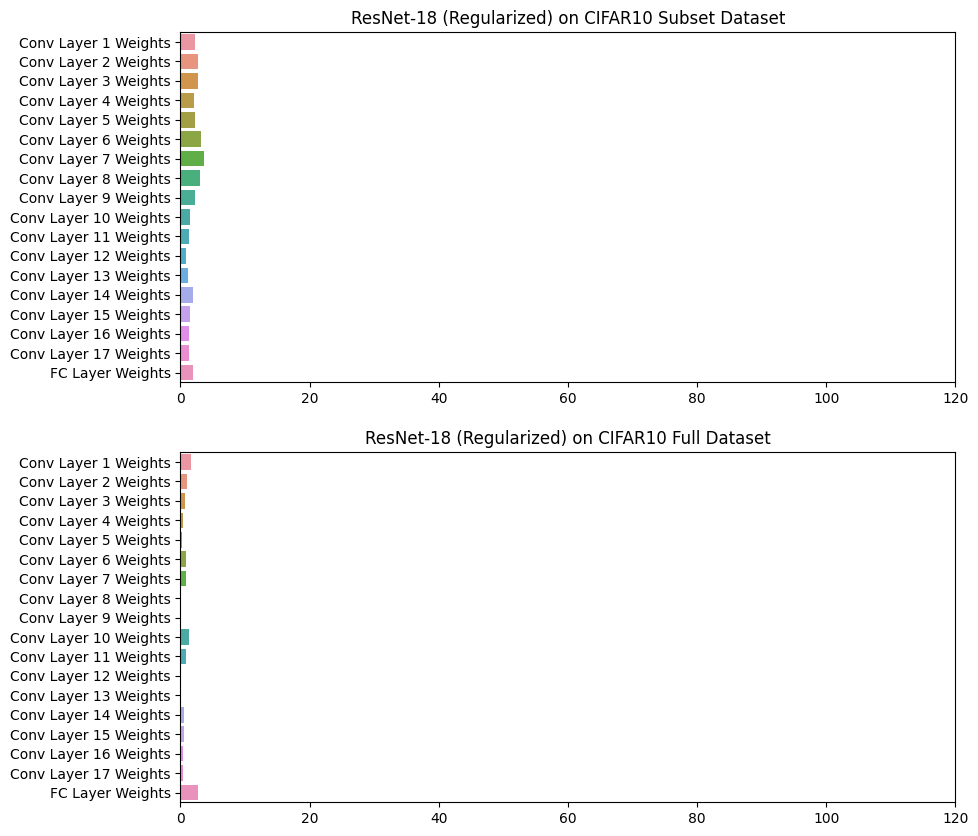

In [20]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (10,10))
layer, norms = zip(*subset_norms.items())
sns.barplot(y = np.array(layer), x = np.array(norms), ax = axes[0])
axes[0].set_xlim(0,120)
axes[0].set_title(model_names[0])
layer, norms = zip(*full_norms.items())
sns.barplot(y = np.array(layer), x = np.array(norms), ax = axes[1])
axes[1].set_xlim(0,120)
axes[1].set_title(model_names[1]);

### Observations: Weight Distributions

- In case of subset datases, with limited data, the model explores a diverse range of weight values, leading to narrower weight distributions.
- In case of full dataset, given the abundance of data, the model learns a broader distribution of weights, capturing more intricate patterns in the data.
- Training on a subset of the data lead to sharper and more peaked weight distributions, indicating potential overfitting. On the other hand, a full dataset results in broader weight distributions, suggesting that the model has captured a wider variety of features.
- If we compare the non-overfit model (non-regularized) with overfit model (regularized) also, we can notice that the distribution of magnitude of weights is larger when the model is overfitting, i.e. weights have larger values when overfit. Also the weights of non-overfit model has very small norm compared to highly overfit model. 
  
Thus to find whether model is overfitting, we can plot norm or distribution of the weights learnt and if the weight distribution have high variance or norm is high, then the model is overfitting.

### Visualizing Kernels of Non-Regularized Models

#### Layer 1

In [21]:
def kernel_visualization(kernels_1, kernels_2, reg = 'Non-Reg'):
    fig, axes = plt.subplots(nrows=8, ncols=17, figsize=(17,8))
    kernels_1 = kernels_1[:64]
    kernels_2 = kernels_2[:64]
    for idx, (kernel1, kernel2) in enumerate(zip(kernels_1, kernels_2)):
        row_num = idx // 8
        col_num1 = idx % 8
        col_num2 = idx % 8 + 9

        # Display the first set of kernels
        if kernel1.ndim == 3:
            axes[row_num][col_num1].imshow(kernel1.permute(1,2,0))
        else:
            axes[row_num][col_num1].imshow(kernel1, cmap = 'gray')
        axes[row_num][col_num1].axis('off')
        
        # Display the second set of kernels
        if kernel2.ndim == 3:
            axes[row_num][col_num2].imshow(kernel2.permute(1,2,0))
        else:
            axes[row_num][col_num2].imshow(kernel2, cmap = 'gray')
        axes[row_num][col_num2].axis('off')

    for row_num in range(8):
        axes[row_num][8].axis('off')
        
    # Add titles for the first and second set of kernels
    axes[0][3].set_title(f"ResNet-18 ({reg}) on CIFAR10 Subset Dataset",fontsize=20)
    axes[0][12].set_title(f"ResNet-18 ({reg}) on CIFAR10 Full Dataset",fontsize=20)

    plt.tight_layout()
    plt.show()

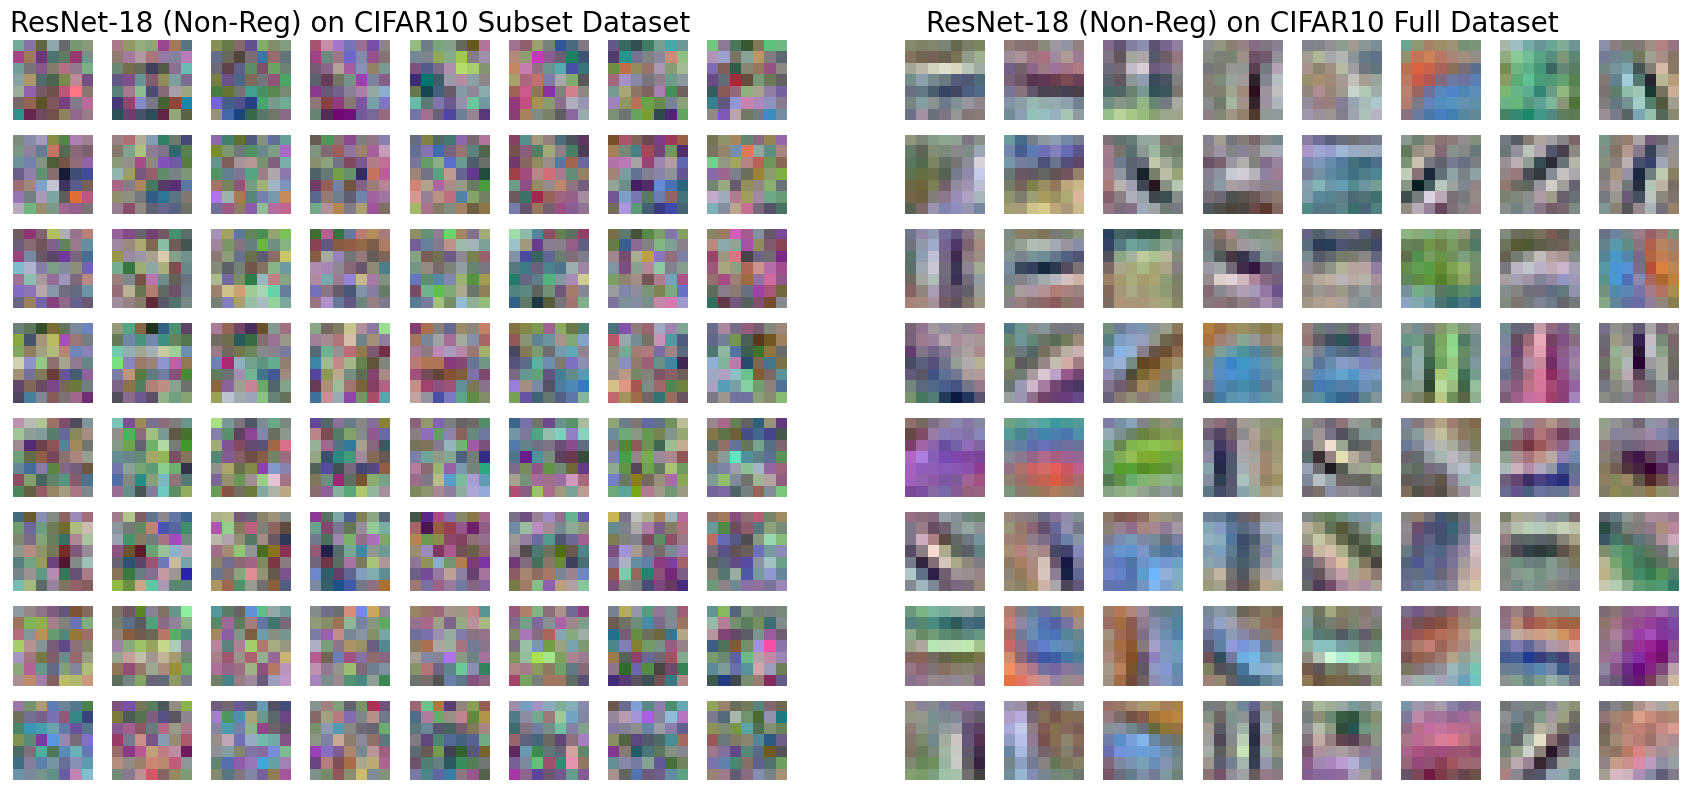

In [22]:
kernels_subset = subset_best_non_regularized.conv1.weight.cpu().detach()    # Plotting Conv1 Layer Weights
kernels_subset = kernels_subset - kernels_subset.min()
kernels_subset = kernels_subset / kernels_subset.max()

kernels_full = Full_best_non_regularized.conv1.weight.cpu().detach()
kernels_full = kernels_full - kernels_full.min()
kernels_full = kernels_full / kernels_full.max()

kernel_visualization(kernels_subset, kernels_full)

#### Layer 2

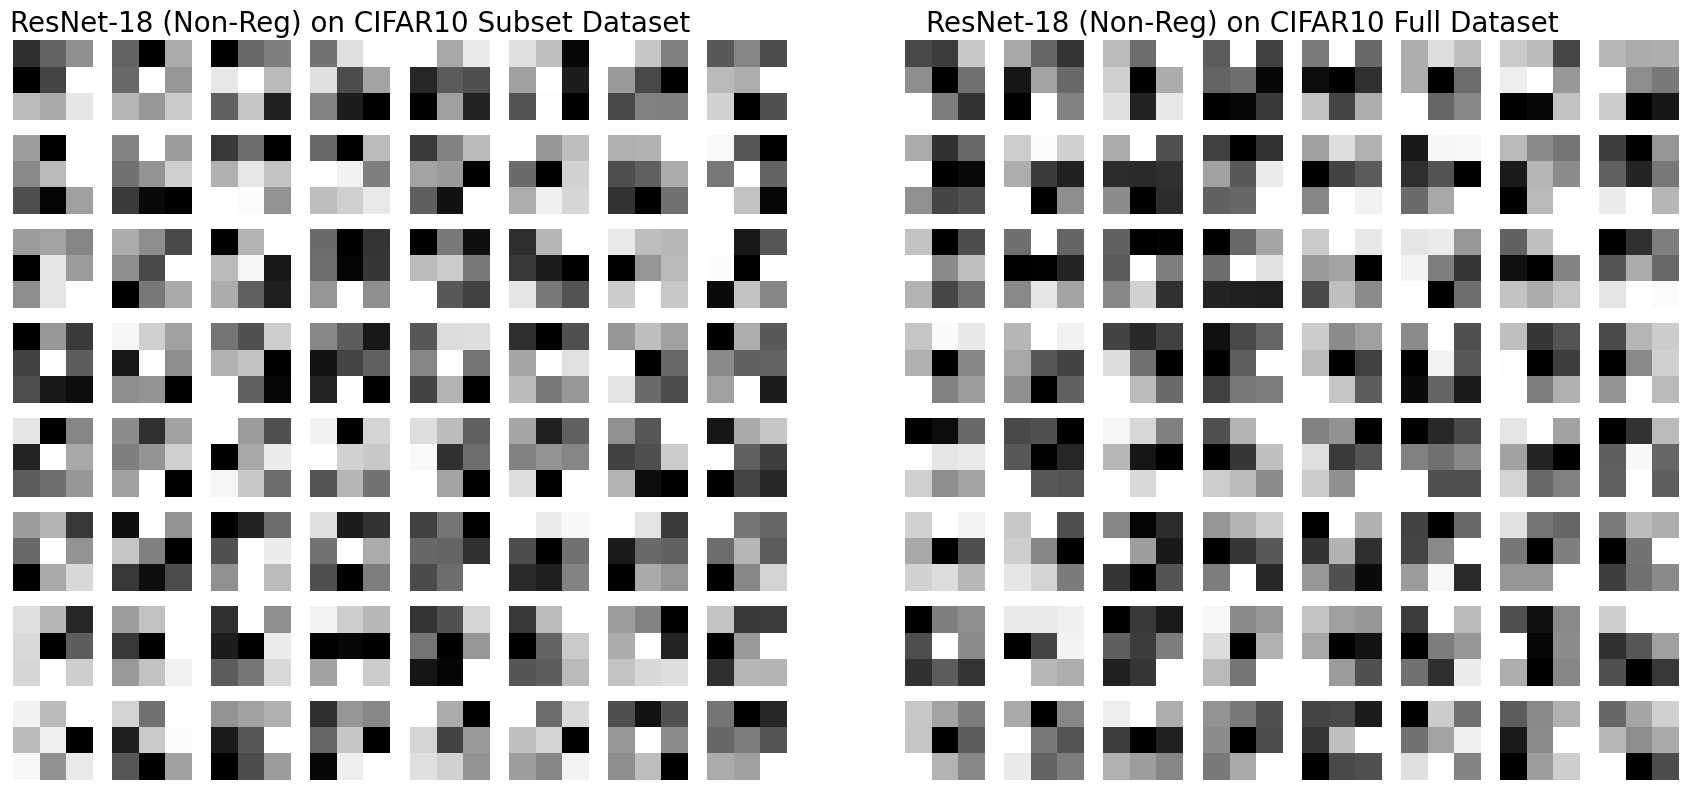

In [23]:
kernels_subset = subset_best_non_regularized.layer1[0].conv1.weight.cpu().detach()    # Plotting second Layer Weights
kernels_subset = kernels_subset - kernels_subset.min()
kernels_subset = kernels_subset / kernels_subset.max()
kernels_subset = kernels_subset.mean(axis = 1)

kernels_full = Full_best_non_regularized.layer1[0].conv1.weight.cpu().detach()
kernels_full = kernels_full - kernels_full.min()
kernels_full = kernels_full / kernels_full.max()
kernels_full = kernels_full.mean(axis = 1)

kernel_visualization(kernels_subset, kernels_full)

#### Last layer

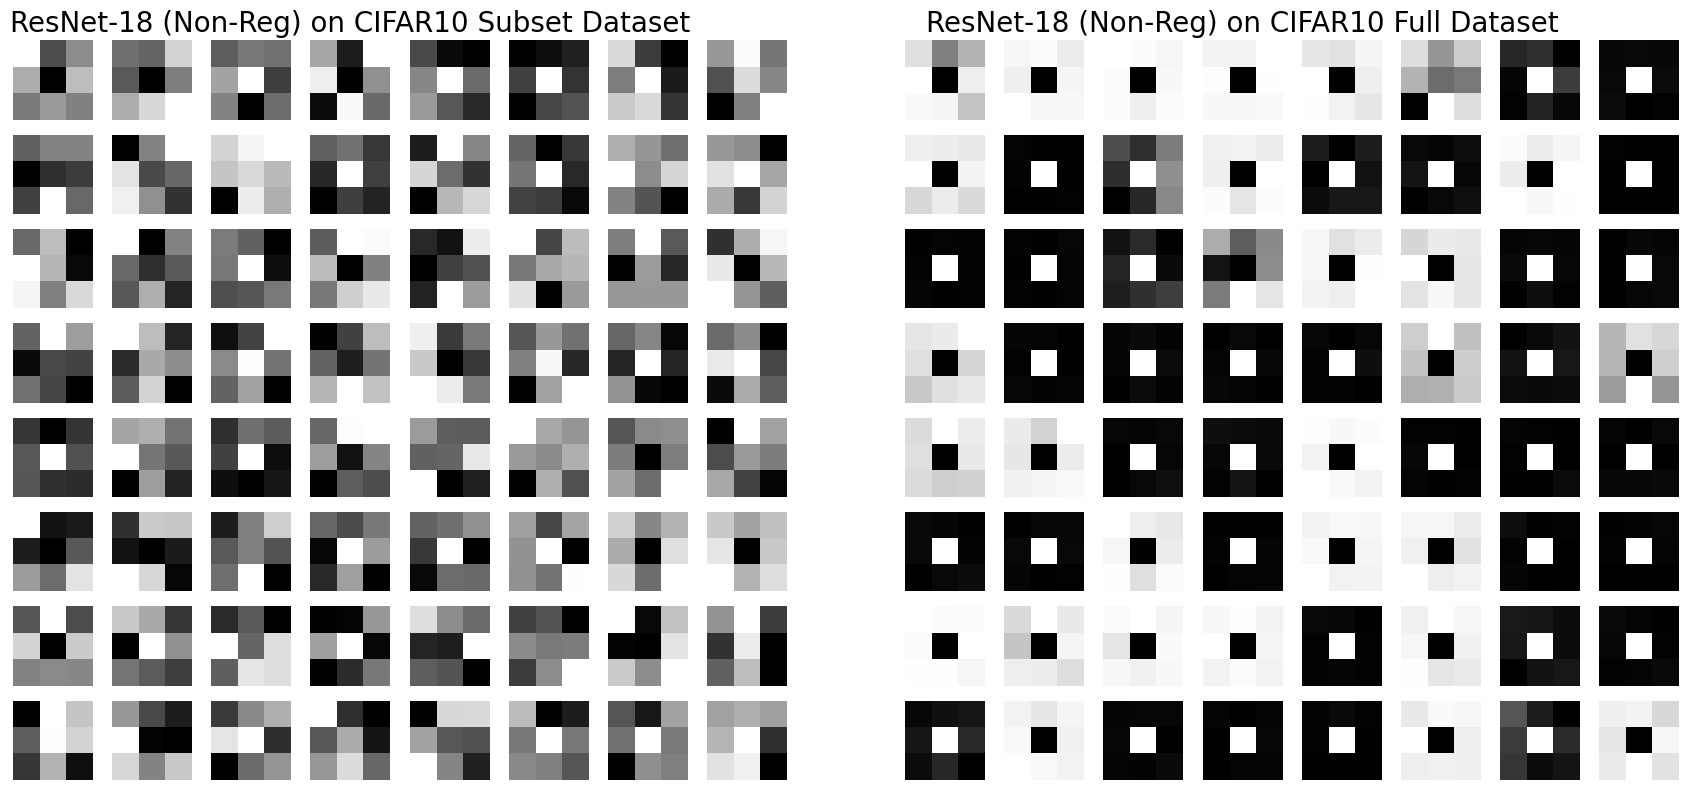

In [24]:
kernels_subset = subset_best_non_regularized.layer4[1].conv1.weight.cpu().detach()    # Plotting last conv weights
kernels_subset = kernels_subset - kernels_subset.min()
kernels_subset = kernels_subset / kernels_subset.max()
kernels_subset = kernels_subset.mean(axis = 1)

kernels_full = Full_best_non_regularized.layer4[1].conv1.weight.cpu().detach()
kernels_full = kernels_full - kernels_full.min()
kernels_full = kernels_full / kernels_full.max()
kernels_full = kernels_full.mean(axis = 1)

kernel_visualization(kernels_subset, kernels_full)

### Visualizing Kernels of Regularized Models

#### Layer 1

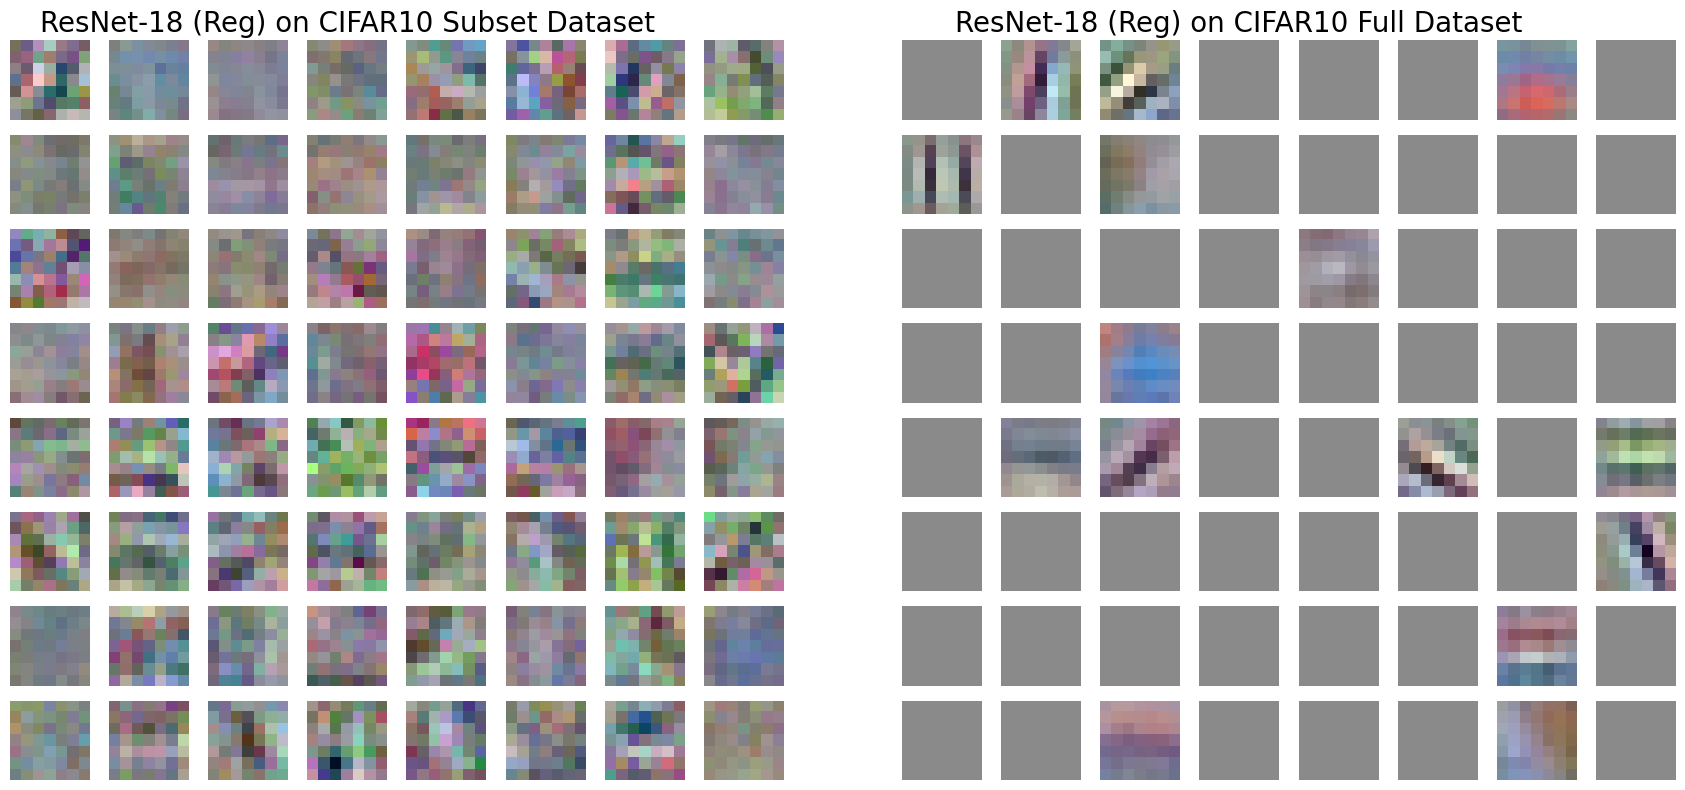

In [25]:
kernels_subset = subset_best_regularized.conv1.weight.cpu().detach()    # Plotting Conv1 Layer Weights
kernels_subset = kernels_subset - kernels_subset.min()
kernels_subset = kernels_subset / kernels_subset.max()

kernels_full = Full_best_regularized.conv1.weight.cpu().detach()
kernels_full = kernels_full - kernels_full.min()
kernels_full = kernels_full / kernels_full.max()

kernel_visualization(kernels_subset, kernels_full, reg = 'Reg')

#### Layer 2

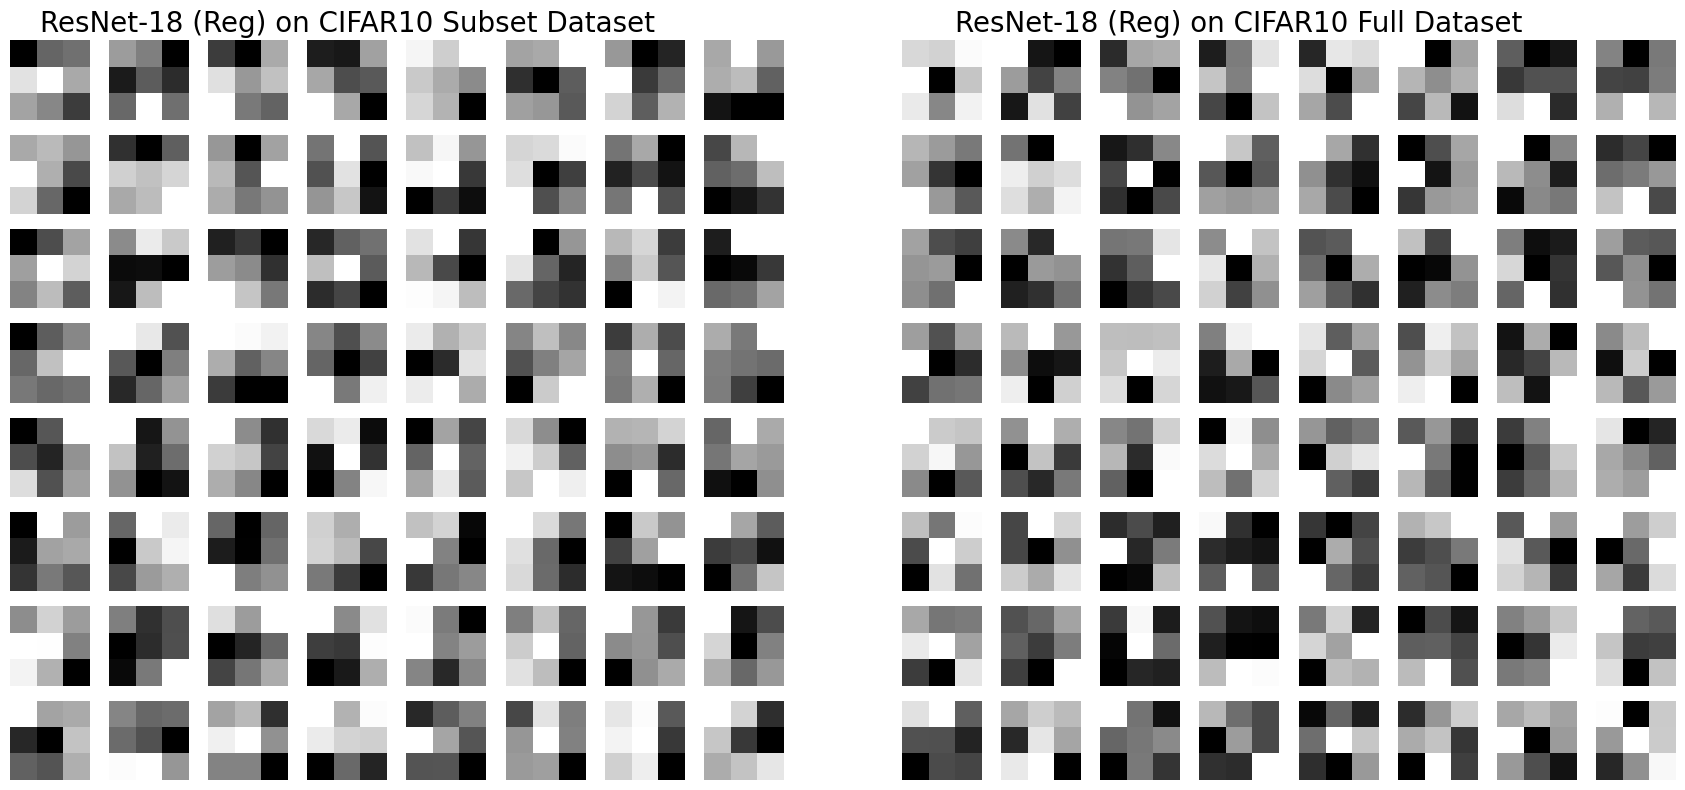

In [26]:
kernels_subset = subset_best_regularized.layer1[0].conv1.weight.cpu().detach()    # Plotting second Layer Weights
kernels_subset = kernels_subset - kernels_subset.min()
kernels_subset = kernels_subset / kernels_subset.max()
kernels_subset = kernels_subset.mean(axis = 1)

kernels_full = Full_best_regularized.layer1[0].conv1.weight.cpu().detach()
kernels_full = kernels_full - kernels_full.min()
kernels_full = kernels_full / kernels_full.max()
kernels_full = kernels_full.mean(axis = 1)

kernel_visualization(kernels_subset, kernels_full, reg = 'Reg')

#### Last Layer

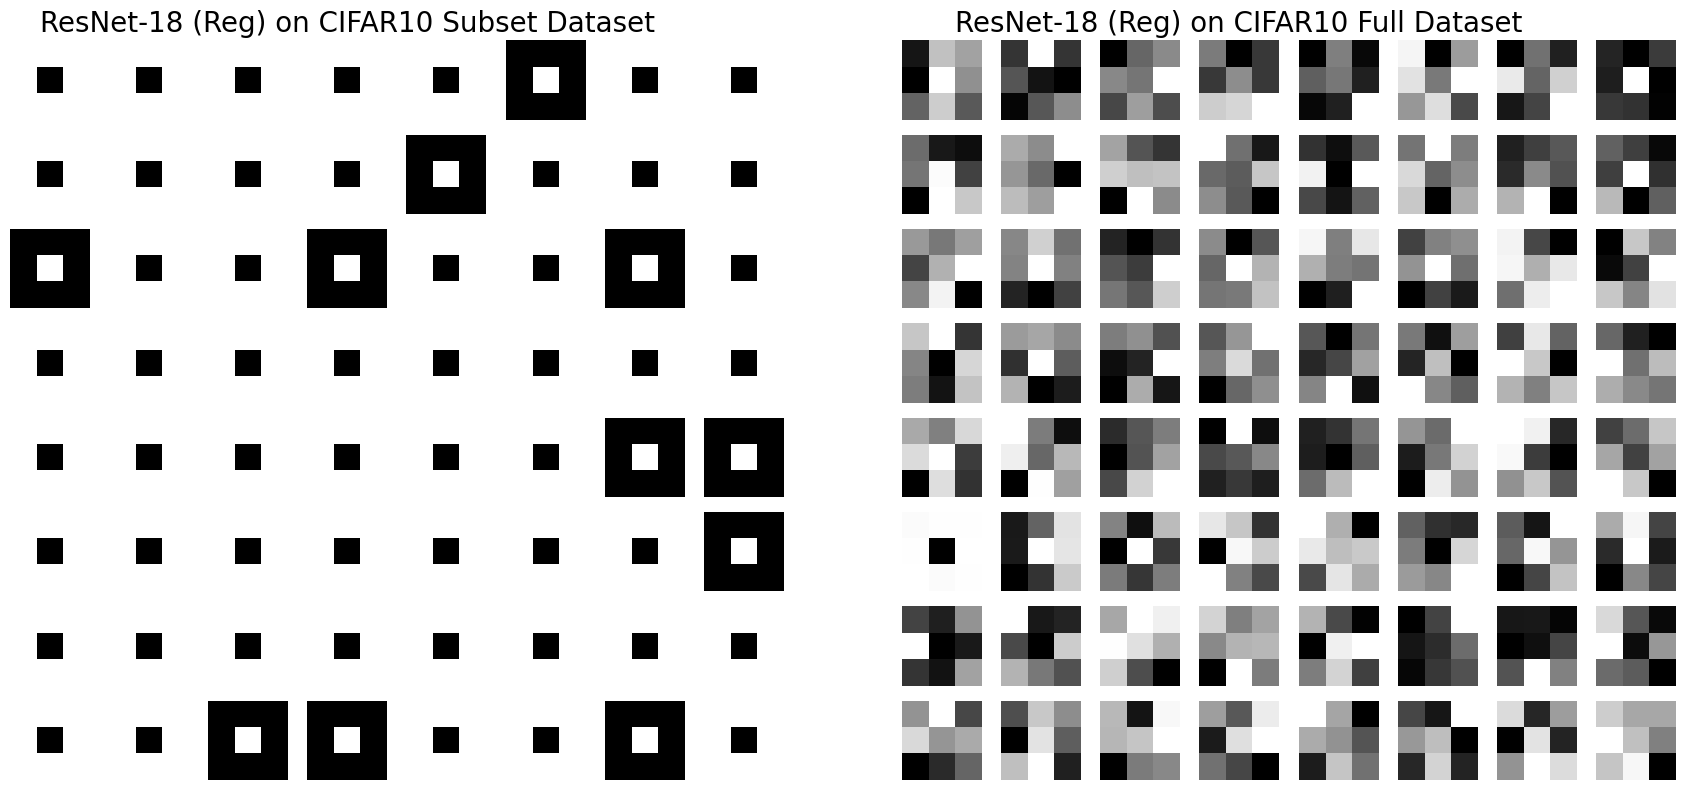

In [27]:
kernels_subset = subset_best_regularized.layer4[1].conv1.weight.cpu().detach()    # Plotting last conv weights
kernels_subset = kernels_subset - kernels_subset.min()
kernels_subset = kernels_subset / kernels_subset.max()
kernels_subset = kernels_subset.mean(axis = 1)

kernels_full = Full_best_regularized.layer4[1].conv1.weight.cpu().detach()
kernels_full = kernels_full - kernels_full.min()
kernels_full = kernels_full / kernels_full.max()
kernels_full = kernels_full.mean(axis = 1)

kernel_visualization(kernels_subset, kernels_full, reg = 'Reg')

### Observations: Visualizing Kernels

- Kernels from the model trained on the subset dataset appear noisier and less structured, likely due to overfitting to a limited set of examples.
- Kernels from the model trained on the full dataset show more recognizable patterns and structures, indicative of the model picking up more general features from the data. We can clearly see in conv1 layer visualizations that the model has learned to detect horizontal and vertical edges, as well as some diagonal edges.  
- Regularization tends to smooth out the appearance of kernels, making them appear less noisy.

### Conclusion
Training on limited data (few training samples per class), especially without regularization, leads to overfitting, where the model becomes too specialized to the training set. Regularization techniques can mitigate this to some extent. On the other hand, training on a full dataset allows the model to learn more generalized features, potentially improving its performance on unseen data. 